# Read, write, subset rasters

In [1]:
import rasterio
import numpy
import geopandas
import contextily
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nightlight_file = rasterio.open('../data/txlights.tif')
nightlights = nightlight_file.read(1)

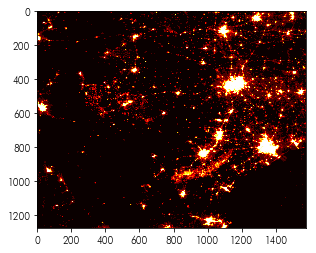

In [3]:
plt.imshow(nightlights, cmap='hot')

In [4]:
neighborhoods = geopandas.read_file('../data/neighborhoods.gpkg')

In [5]:
austin_bbox = neighborhoods.total_bounds

In [6]:
nightlight_file.window?

Signature: nightlight_file.window(left, bottom, right, top, precision=None)
Docstring:
Get the window corresponding to the bounding coordinates.

The resulting window is not cropped to the row and column
limits of the dataset.

Parameters
----------
left: float
    Left (west) bounding coordinate
bottom: float
    Bottom (south) bounding coordinate
right: float
    Right (east) bounding coordinate
top: float
    Top (north) bounding coordinate
precision: int, optional
    Number of decimal points of precision when computing inverse
    transform.

Returns
-------
window: Window
File:      ~/anaconda3/envs/ana/lib/python3.7/site-packages/rasterio/windows.py
Type:      method


In [7]:
austin_window = nightlight_file.window(*neighborhoods.total_bounds)

In [8]:
austin_nightlights = nightlight_file.read(1, window=austin_window)

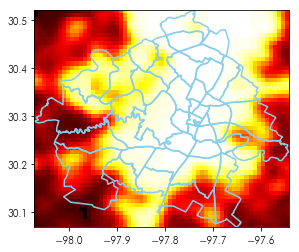

In [9]:
plt.imshow(austin_nightlights, extent=neighborhoods.total_bounds[[0,2,1,3]], cmap='hot')
neighborhoods.boundary.plot(ax=plt.gca(), color='skyblue')

In [10]:
austin_transform = nightlight_file.window_transform(austin_window)

In [11]:
with rasterio.open('../data/austinlights.tif', 'w', driver='GTiff', 
                   height=austin_nightlights.shape[0], 
                   width=austin_nightlights.shape[1], 
                   count=1, dtype=rasterio.ubyte, 
                   crs=nightlight_file.crs, 
                   transform=austin_transform) as outfile:
    outfile.write(austin_nightlights, 1)

In [12]:
basemap, basemap_extent = contextily.bounds2img(*neighborhoods.to_crs(epsg=3857).total_bounds, zoom=10)

# Zonalstats

what's the average brightness at night within each of the neighborhoods?

In [13]:
from rasterio.mask import mask

array([-97.928875, -97.846623,  30.139555,  30.218407])

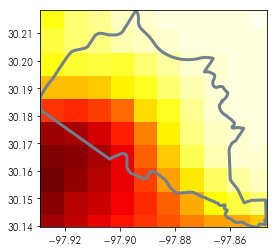

In [14]:
test_shape = neighborhoods.geometry[[0]]
plt.imshow(austin_nightlights, extent=neighborhoods.total_bounds[[0,2,1,3]], cmap='hot')
test_shape.boundary.plot(ax = plt.gca(), color='slategrey', linewidth=3)
plt.axis(test_shape.total_bounds[[0,2,1,3]])

In [15]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True)

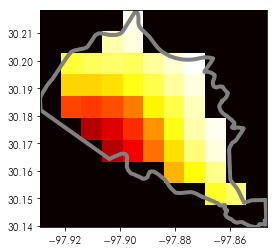

In [16]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [17]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, all_touched=True)

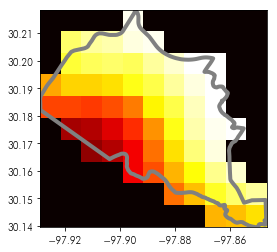

In [18]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [19]:
masked.mean()

24.490909090909092

In [20]:
masked

array([[[ 0,  0,  0,  0, 59,  0,  0,  0,  0,  0,  0],
        [ 0, 51, 54, 55, 58, 59,  0,  0,  0,  0,  0],
        [ 0, 48, 50, 51, 50, 54, 57, 60, 60,  0,  0],
        [37, 41, 41, 42, 46, 49, 54, 58, 60,  0,  0],
        [28, 28, 27, 29, 33, 44, 49, 56, 60,  0,  0],
        [ 0, 14, 15, 19, 26, 35, 46, 55, 59, 60,  0],
        [ 0,  0, 12, 15, 21, 32, 42, 52, 58,  0,  0],
        [ 0,  0,  0,  0, 21, 29, 38, 45, 53, 57,  0],
        [ 0,  0,  0,  0,  0,  0, 32, 39, 47, 51, 54],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 38, 39, 42]]], dtype=uint8)

In [21]:
masked[masked.nonzero()].mean()

43.45161290322581

In [22]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, all_touched=True, 
                              filled=False)

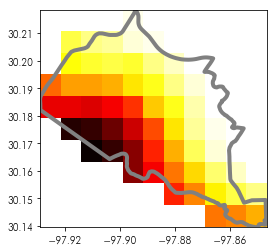

In [23]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

In [24]:
masked.mean()

43.45161290322581

In [25]:
neighborhoods['nightlights'] = neighborhoods.geometry.apply(lambda geom: mask(dataset=nightlight_file, 
                                               shapes=(geom, ), 
                                               crop=True, all_touched=True, 
                                               filled=False)[0].mean())

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

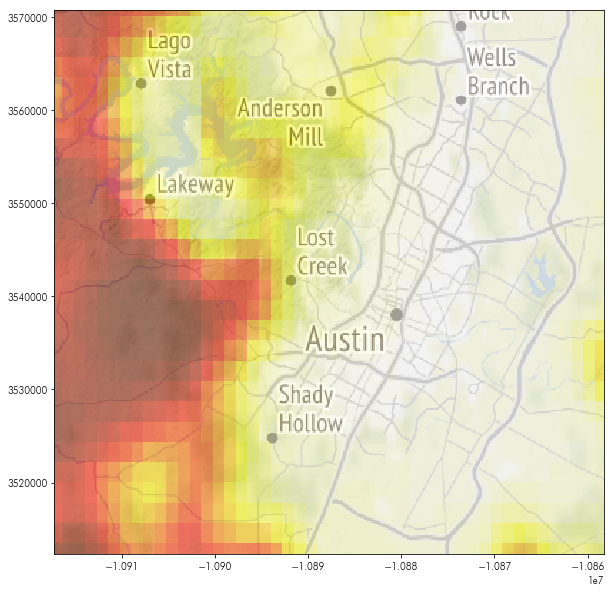

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
plt.imshow(austin_nightlights, extent=basemap_extent, alpha=.5, cmap='hot')
plt.axis(neighborhoods.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

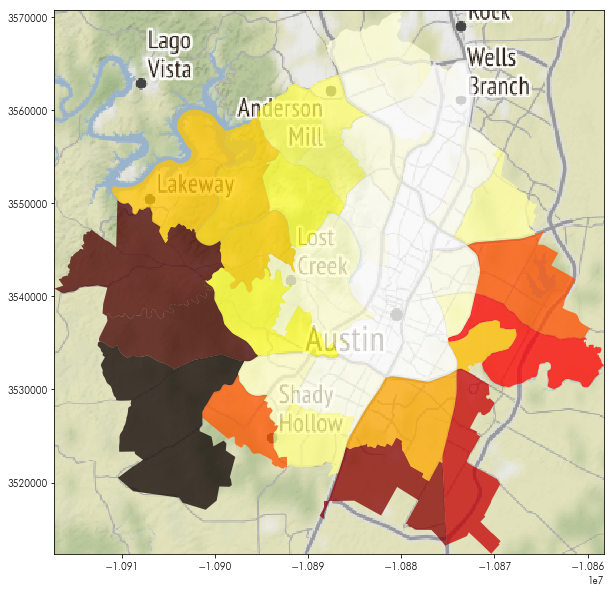

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
neighborhoods.to_crs(epsg=3857).plot('nightlights', 
                                     cmap='hot', ax = plt.gca(), alpha=.75)
plt.axis(neighborhoods.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

## Getting values at cells?

In [28]:
listings = geopandas.read_file('../data/listings.gpkg')

In [29]:
brightnesses = nightlight_file.sample(listings[['longitude', 'latitude']].values)

In [30]:
listings['brightness'] = numpy.vstack(brightnesses)

array([-10915271.25647279, -10860398.53987606,   3516163.35327712,
         3569570.08939497])

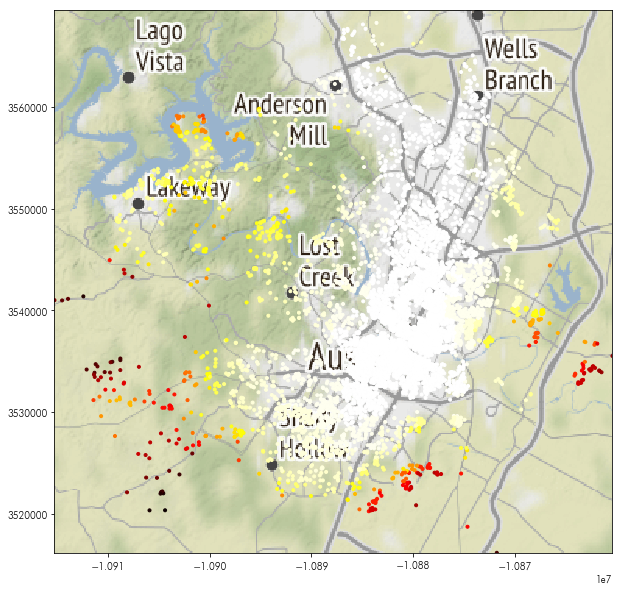

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
listings.to_crs(epsg=3857).plot('brightness', ax=plt.gca(), 
                                marker='.', cmap='hot')
plt.axis(listings.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

In [32]:
listings['price'] = listings.price.str.replace('$', '').str.replace(',', '_').astype(float)

In [33]:
listings = listings[(listings.price > listings.price.quantile(.01)) 
                    & (listings.price < listings.price.quantile(.99))]

Text(0, 0.5, 'BRIGHTNESS')

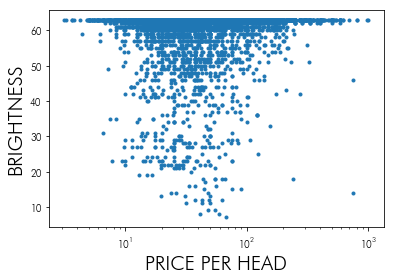

In [34]:
plt.semilogx(listings.eval('(price/accommodates)'), 
             listings.brightness, marker='.', linewidth=0)
plt.xlabel('Price Per Head'.upper(), fontsize=20)
plt.ylabel('Brightness'.upper(), fontsize=20)